# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [29]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100, CIFAR10
from torchvision.transforms import ToTensor, Compose
import torch
from tqdm import tqdm
import wandb
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class CIFAR100_wrapper(Dataset):

    def __init__(self, classes: set[int], get_train: bool = True) -> None:
        super().__init__()
        self.classes = classes
        cifar = CIFAR100("~/datasets", download=get_train, train=get_train, transform=Compose([ToTensor()]))
        samples = []
        labels = []
        for i in range(len(cifar)):
            if cifar[i][1] in classes:
                samples.append(cifar[i][0])
                labels.append(torch.Tensor([cifar[i][1]]).long())
        self.data = torch.stack(samples)
        self.labels = torch.cat(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]: return self.data[index], self.labels[index]

index_id = set(range(20))
index_ood = set(range(30, 40))

batch_size=64

c20 = CIFAR100_wrapper(index_id)
c20_train, c20_val = random_split(c20, [0.7, 0.3])
c20_test = CIFAR100_wrapper(index_id)
c20_ood = CIFAR100_wrapper(index_ood)
dl_train = DataLoader(c20_train, batch_size, shuffle=True)
dl_val = DataLoader(c20_val, batch_size, shuffle=True)
dl_test = DataLoader(c20_test, batch_size, shuffle=True)
dl_ood = DataLoader(c20_ood, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
@torch.no_grad()
def ood_test(model, dataloader, threshold = 1.):
    max_logits = []
    second_guess = []
    for x, _ in dataloader:
        x = x.to(device)
        logits_sorted, _ = torch.sort(model(x), descending=True)
        max_logits.append(logits_sorted[:, 0])
        second_guess.append(logits_sorted[:, 1])
    max_logits = torch.cat(max_logits)
    second_guess = torch.cat(second_guess)
    return (max_logits - second_guess) > threshold

@torch.no_grad()
def ood_score(model, dataloader):
    max_logits = []
    second_guess = []
    for x, _ in dataloader:
        x = x.to(device)
        logits_sorted, _ = torch.sort(model(x), descending=True)
        max_logits.append(logits_sorted[:, 0])
        second_guess.append(logits_sorted[:, 1])
    max_logits = torch.cat(max_logits)
    second_guess = torch.cat(second_guess)
    return (max_logits - second_guess)

# Model (note for me: OK)
A simple model for classification

In [4]:
class CifarClassifier(nn.Module):

    def __init__(self, n_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.dropout1 = nn.Dropout()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2)
        self.dropout2 = nn.Dropout()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(nn.Linear(784*2, 1000), nn.ReLU(), nn.Linear(1000, n_classes))

    def forward(self, X):
        X = F.relu(self.dropout1(self.conv1(X)))
        X = self.pool1(X)
        X = F.relu(self.dropout2(self.conv2(X)))
        X = self.pool2(X)
        X = self.flatten(X)
        return self.head(X)


# CIFAR10 dataset

In [5]:
cifar = CIFAR10("~/datasets", transform=Compose([ToTensor() # ,
     # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))
c_train, c_val = random_split(cifar, [0.7, 0.3])
dl_train = DataLoader(c_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(c_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(CIFAR10("~/datasets", train=False, transform=ToTensor()), batch_size=batch_size, shuffle=True)

In [6]:
n_classes = 10
res = 32
i_channels = 3
e_channels = 32
n_convs = 16
# model = RCNN(res, i_channels, e_channels, n_convs, n_classes).to(device)
model = CifarClassifier(n_classes).to(device)
x = torch.rand((16, 3, 32, 32)).to(device)
model(x).shape

torch.Size([16, 10])

## Training

In [7]:
@torch.no_grad()
def validation(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

In [8]:
def training(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [ ]:
loss_fn = F.cross_entropy
epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training(model, dl_train, dl_val, loss_fn, optim, epochs, 5, False)

In [ ]:
id_data = ood_score(model, dl_test)
ood_data = ood_score(model, dl_ood)

In [ ]:
plt.hist(id_data.cpu(), bins=30, density=True, alpha=0.5, label="ID")
plt.hist(ood_data.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
plt.legend()
plt.show()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [9]:
# Your code here.
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_score, recall_score
@torch.no_grad()
def ood_roc_test(model, dataloader_id, dataloader_ood, threshold = 0.4):
    predictions = torch.cat((ood_test(model, dataloader_id, threshold), ood_test(model, dataloader_ood, threshold)), dim=0)
    true_values = torch.cat((torch.ones(len(dataloader_id.dataset)), torch.zeros(len(dataloader_ood.dataset))), dim=0) 
    # print(len(dataloader_ood.dataset), len(dataloader_id.dataset), len(true_values), len(predictions))
    RocCurveDisplay.from_predictions(true_values, predictions.cpu())
    PrecisionRecallDisplay.from_predictions(true_values, predictions.cpu())


In [ ]:
ood_roc_test(model, dl_test, dl_ood)

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [ ]:
r = torch.randn((10)) * 10
r

In [ ]:
s = r.sign()
s

In [10]:
# Your code here.
def fgs_perturbation(model: torch.nn.Module, batch: torch.Tensor, batch_label: torch.Tensor, loss_fn, epsilon: float = 0.01):
    # gradient wrt input
    batch.requires_grad = True
    model.requires_grad_ = False
    logits = model(batch)
    loss = loss_fn(logits, batch_label)
    loss.backward()
    perturbation = batch.grad.data # gradient
    perturbation = perturbation.sign() # signed gradient
    perturbation = epsilon * perturbation # scaled perturbation
    return perturbation

In [ ]:
for x, y in dl_train:
    batch, batch_labels = x, y
    break

In [ ]:
plt.imshow(batch[0].transpose(0, 1).transpose(1, 2))

In [ ]:
cols = 4
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy)
    perturbed = x + pert
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

In [ ]:
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
epsilons = [0.01, 0.02, 0.05, 0.1]
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy, epsilon=epsilons[i])
    perturbed = x + pert
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

In [ ]:
def validation_perturbated(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        pert = fgs_perturbation(model, x, y, loss_fn, 0.)
        x = x + pert
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

validation_perturbated(model, dl_test, F.cross_entropy)

In [ ]:
perturbed.shape

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [13]:
# Your code here.
def augment_batch(model, batch, batch_labels, loss, epsilon=0.01):
    pert = fgs_perturbation(model, batch, batch_labels, loss, epsilon)
    augmented_data = batch + pert
    batch = torch.cat([batch, augmented_data], dim=0)
    batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
    return batch, batch_labels

batch, batch_labels = batch.to(device), batch_labels.to(device)
aug, aug_l = augment_batch(model, batch, batch_labels, F.cross_entropy)
print(batch.shape, aug.shape)

NameError: name 'batch' is not defined

In [11]:
# NOTE  l'augment fatto in questo modo implica che il batch size effettivo è doppio rispetto a quello dichiarato (=64) 
def training_with_augment(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            x, y = augment_batch(model, x, y, loss_fn)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [ ]:
loss_fn = F.cross_entropy
model = CifarClassifier(n_classes).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training_with_augment(model, dl_train, dl_val, loss_fn, optim, epochs, 5, False)

In [ ]:
ood_roc_test(model, dl_test, dl_ood, 1)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

## Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

In [12]:
class CifarClassifierWithODIN(nn.Module):

    def __init__(self, n_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.dropout1 = nn.Dropout()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2)
        self.dropout2 = nn.Dropout()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(nn.Linear(784*2, 1000), nn.ReLU(), nn.Linear(1000, n_classes))

    def forward(self, X, T = 1):
        X = F.relu(self.dropout1(self.conv1(X)))
        X = self.pool1(X)
        X = F.relu(self.dropout2(self.conv2(X)))
        X = self.pool2(X)
        X = self.flatten(X)
        return self.head(X) / T

In [13]:
# Your code here.

def odin_perturbation(model: torch.nn.Module, batch: torch.Tensor, epsilon: float = 0.01):
    # gradient wrt input
    batch.requires_grad = True
    model.requires_grad_ = False
    logits = model(batch)
    probabilities, _ = torch.max(F.log_softmax(logits, dim=1), dim=1)
    probabilities.sum().backward()

    perturbation = -batch.grad.data # gradient
    perturbation = perturbation.sign() # signed gradient
    perturbation = epsilon * perturbation # scaled perturbation
    return perturbation

def odin_augment(model, batch, epsilon=0.01):
    pert = odin_perturbation(model, batch, epsilon)
    augmented_data = batch - pert
    # batch = torch.cat([batch, augmented_data], dim=0)
    # batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
    return augmented_data

In [21]:
def ood_odin_classication(model, dataloader, temperature, threshold = .3):
    probs = []
    for x, _ in dataloader:
        x = x.to(device)
        x = odin_augment(model, x)
        prob, _ = torch.max(F.softmax(model(x, temperature), dim=1), dim=1)
        probs.append(prob)
    probs = torch.cat(probs, dim=0)
    return probs > threshold


In [15]:
# Your code here.
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
def ood_odin_test(model, dataloader_id, dataloader_ood, temperature, threshold):
    predictions = torch.cat((ood_odin_classication(model, dataloader_id, temperature, threshold), ood_odin_classication(model, dataloader_ood, temperature, threshold)), dim=0)
    true_values = torch.cat((torch.ones(len(dataloader_id.dataset)), torch.zeros(len(dataloader_ood.dataset))), dim=0).to(device)
    # print(len(dataloader_ood.dataset), len(dataloader_id.dataset), len(true_values), len(predictions))
    # compute true positive and false positive
    tp = (predictions == 1) * (true_values == 1)
    fp = (predictions == 1) * (true_values == 0)

    # compute true negative and false negative
    tn = (predictions == 0) * (true_values == 0)
    fn = (predictions == 0) * (true_values == 1)
    return tp.sum().item(), fp.sum().item(), tn.sum().item(), fn.sum().item()
    # RocCurveDisplay.from_predictions(true_values, predictions.cpu(), name=f"T={temperature}, eps={threshold}")
    # PrecisionRecallDisplay.from_predictions(true_values, predictions.cpu())

In [22]:
n_classes = 10
epochs = 30
odin_model = CifarClassifierWithODIN(n_classes).to(device)
optimizer = torch.optim.Adam(odin_model.parameters(), lr=0.001)
loss = F.cross_entropy
training(odin_model, dl_train, dl_val, loss, optimizer, epochs, 5, False)

Loss Train = 0.9252255844459674, Loss Val = 1.2712334830710228, Acc = 0.6056666666666667


Loss Train = 0.5408912023743938, Loss Val = 1.0569293105855901, Acc = 0.6466666666666666


Loss Train = 0.30398687891920917, Loss Val = 1.001981667762107, Acc = 0.6526


Loss Train = 0.20726991897717909, Loss Val = 1.038426000513929, Acc = 0.6416666666666667


Loss Train = 0.1611172705105552, Loss Val = 1.0545814800769724, Acc = 0.65


Loss Train = 0.13204438556360262, Loss Val = 1.0512549062992664, Acc = 0.6544666666666666


([1.2712334830710228,
  1.0569293105855901,
  1.001981667762107,
  1.038426000513929,
  1.0545814800769724,
  1.0512549062992664],
 [0.6056666666666667,
  0.6466666666666666,
  0.6526,
  0.6416666666666667,
  0.65,
  0.6544666666666666])

10000 5000 0 0
10000 5000 0 0
10000 5000 0 0
10000 5000 0 0
9999 5000 0 1
9999 5000 0 1
9997 4998 2 3
9993 4994 6 7
9992 4990 10 8
9986 4986 14 14
9963 4964 36 37
9923 4926 74 77
9813 4824 176 187
10000 5000 0 0
9999 5000 0 1
9996 4995 5 4
9984 4982 18 16
9951 4935 65 49
9836 4832 168 164
9635 4617 383 365
9280 4271 729 720
8763 3794 1206 1237
8050 3207 1793 1950
7185 2552 2448 2815
6173 1895 3105 3827
5128 1267 3733 4872
9999 4999 1 1
9986 4981 19 14
9869 4869 131 131
9543 4514 486 457
8892 3916 1084 1108
7951 3128 1872 2049
6867 2322 2678 3133
5767 1623 3377 4233
4673 1062 3938 5327
3771 675 4325 6229
2896 377 4623 7104
2154 189 4811 7846
1483 86 4914 8517
9992 4987 13 8
9803 4774 226 197
9051 4033 967 949
7704 2944 2056 2296
6206 1922 3078 3794
4780 1122 3878 5220
3682 629 4371 6318
2724 331 4669 7276
1970 154 4846 8030
1393 67 4933 8607
935 29 4971 9065
632 17 4983 9368
395 6 4994 9605
9917 4899 101 83
9050 4042 958 950
7168 2543 2457 2832
5225 1352 3648 4775
3694 637 4363 6306
252

ZeroDivisionError: division by zero

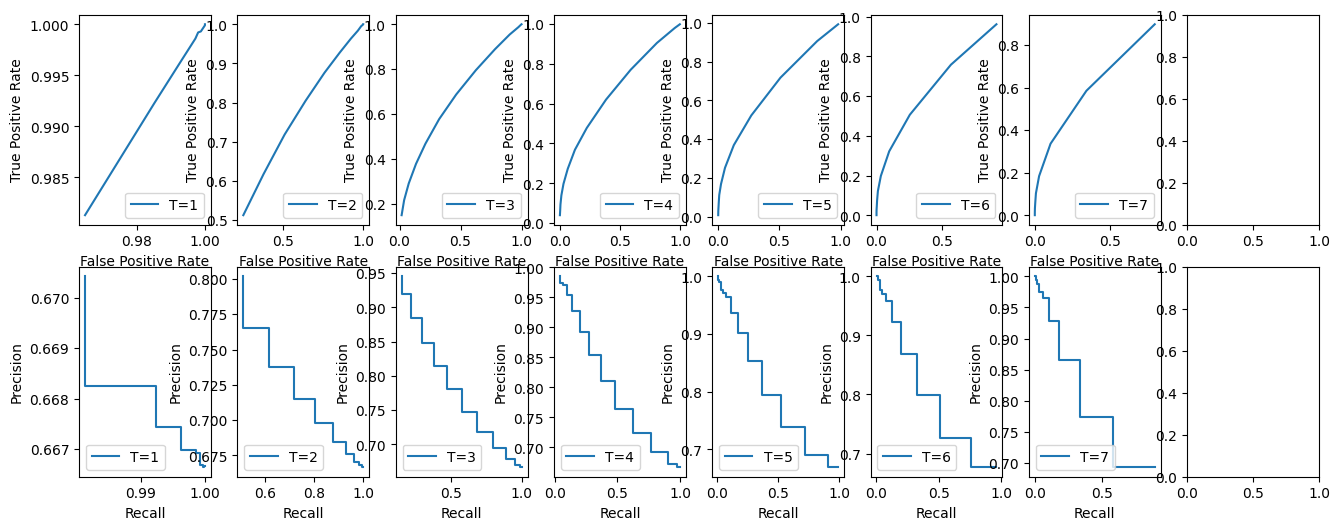

In [30]:
temperatures = [i for i in range(1, 8)]
cols = len(temperatures)
epsilons = [.05 * i for i in range(4, 17)]
rows=2
fig, axes = plt.subplots(rows, cols, figsize=(20, 8))
for c, T in enumerate(temperatures):
    tpr = [] # MEMO: equivale alla recall
    fpr = []
    precision = []
    # recall = []
    for eps in epsilons:
        tp, fp, tn, fn = ood_odin_test(odin_model, dl_test, dl_ood, T, eps)
        print(tp, fp, tn, fn)
        tpr.append((tp / (tp + fn)))
        fpr.append((fp / (fp + tn)))
        precision.append((tp / (tp + fp)))
        # recall.append(tp / (tp + fn))
        # print(tp + fn, fp + tn)
    fpr = np.array(fpr)
    tpr=np.array(tpr)
    # print(fpr, tpr)
    rcd = RocCurveDisplay(fpr=np.array(fpr), tpr=np.array(tpr))
    prd = PrecisionRecallDisplay(recall=np.array(tpr), precision=np.array(precision))
    rcd.plot(name=f"T={T}", ax=axes[0][c])
    prd.plot(name=f"T={T}", ax=axes[1][c])